## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [6]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
#%matplotlib qt
%matplotlib inline

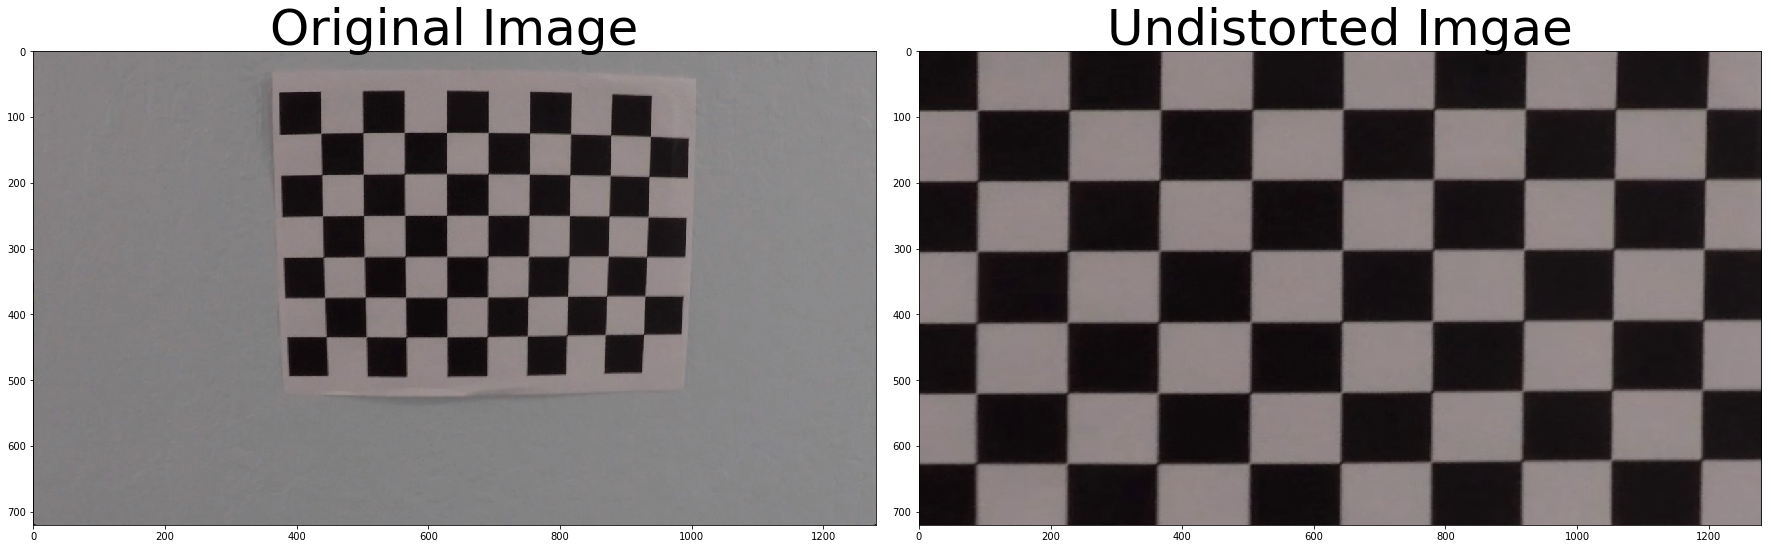

In [81]:
# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
#images = glob.glob('../test_images/test1.jpg')

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    nx = 9
    ny = 6

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Undistort using mtx and dist
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints,\
                                                      imgpoints, img.shape[1:], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        offset = 100 # offset for dst points
        img_size = (gray.shape[1], gray.shape[0])
        
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        dst = np.float32([[offset, offset], [img_size[0]-offset, offset],\
                         [img_size[0]-offset, img_size[1]-offset],\
                         [offset, img_size[1]-offset]])
        M = cv2.getPerspectiveTransform(src, dst)
        
        warped = cv2.warpPerspective(undist, M, img_size)
        
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        #cv2.imshow('img',img)
        #plt.imshow(img)
        #cv2.waitKey(500) 
        
#cv2.destroyAllWindows()
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted Imgae', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [60]:
print('mtx:{}'.format(mtx))

mtx:[[  1.15777920e+03   0.00000000e+00   6.67109905e+02]
 [  0.00000000e+00   1.15282308e+03   3.86127431e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]


# Pipeline
## 1. Provide an example of a distortion-corrected image.

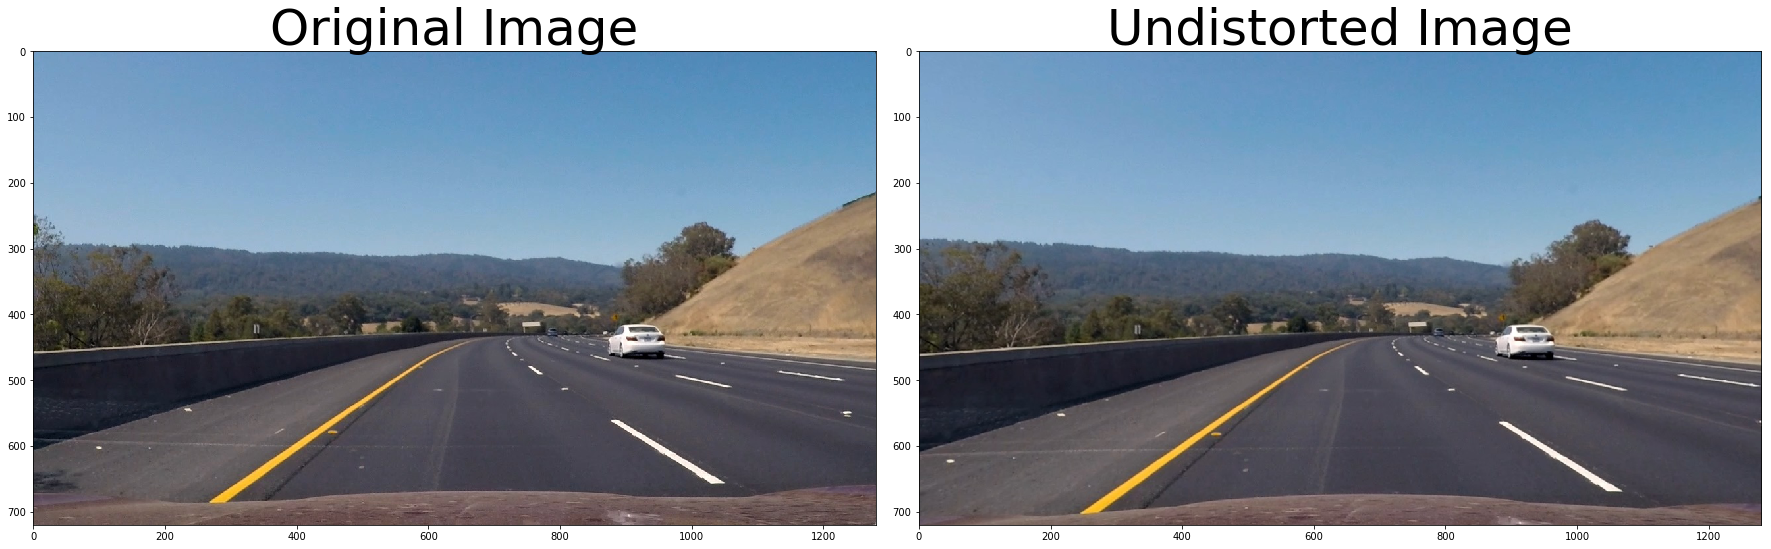

In [61]:
from PIL import Image

test_img = np.array(Image.open('../test_images/test3.jpg'))

undist_img = cv2.undistort(test_img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(test_img, cmap='gray')
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img, cmap='gray')
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image. Provide an example of a binary image result.

Use color transforms, gradients, etc., to create a thresholded binary image.

In [62]:
def mag_select(img, sobel_kernel=3, mag_thresh=(0,255)):
    # 1) Convert to grayscale
    gray_test_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray_test_img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray_test_img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    abs_sobelxy = np.sqrt(np.square(sobelx)+np.square(sobely))
    
    # 4) Scale to 8-bit (0-255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobelxy/np.max(abs_sobelxy))
    
    # 5) Create a binary mask where mag thresholds are met
    thresh_min = mag_thresh[0]
    thresh_max = mag_thresh[1]
    
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

def s_select(img, s_thresh=(0,255)):
    #1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #2) Apply a threshold to the S channel
    S = hls[:,:,2]
    
    #3) Return a binary image of threshold result
    binary_output = np.zeros_like(S)
    binary_output[(S > s_thresh[0]) & (S <= s_thresh[1])] = 1
    
    return binary_output

def h_select(img, h_thresh=(0,255)):
    #1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    #2) Apply a threshold to the H channel
    H = hls[:,:,0]
    
    #3) Return a binary image of threshold result
    binary_output = np.zeros_like(H)
    binary_output[(H > h_thresh[0]) & (H <= h_thresh[1])] = 1
    
    return binary_output

def threshold_pipeline(img, h_thresh=(18,100), s_thresh=(90,255),\
                      mag_thresh=(20,100)):
    # Magnitude 
    mag_binary = mag_select(img, sobel_kernel=3, mag_thresh=(20,100))
    print('mag size:{}'.format(mag_binary.shape))
    
    # Saturation
    s_binary = s_select(img, s_thresh=(80,255))
    print('s size:{}'.format(s_binary.shape))
        
    # Hue
    #h_binary = h_select(img, h_thresh=(20,100))
    #print('h size:{}'.format(h_binary.shape))
        
    # Stack each channel
    #result = np.dstack((np.zeros_like(mag_binary), mag_binary, s_binary))*255
    result = np.zeros_like(s_binary)
    result[(mag_binary == 1) | (s_binary == 1)] = 1
    
    return result
    

mag size:(720, 1280)
s size:(720, 1280)
combined size:(720, 1280)


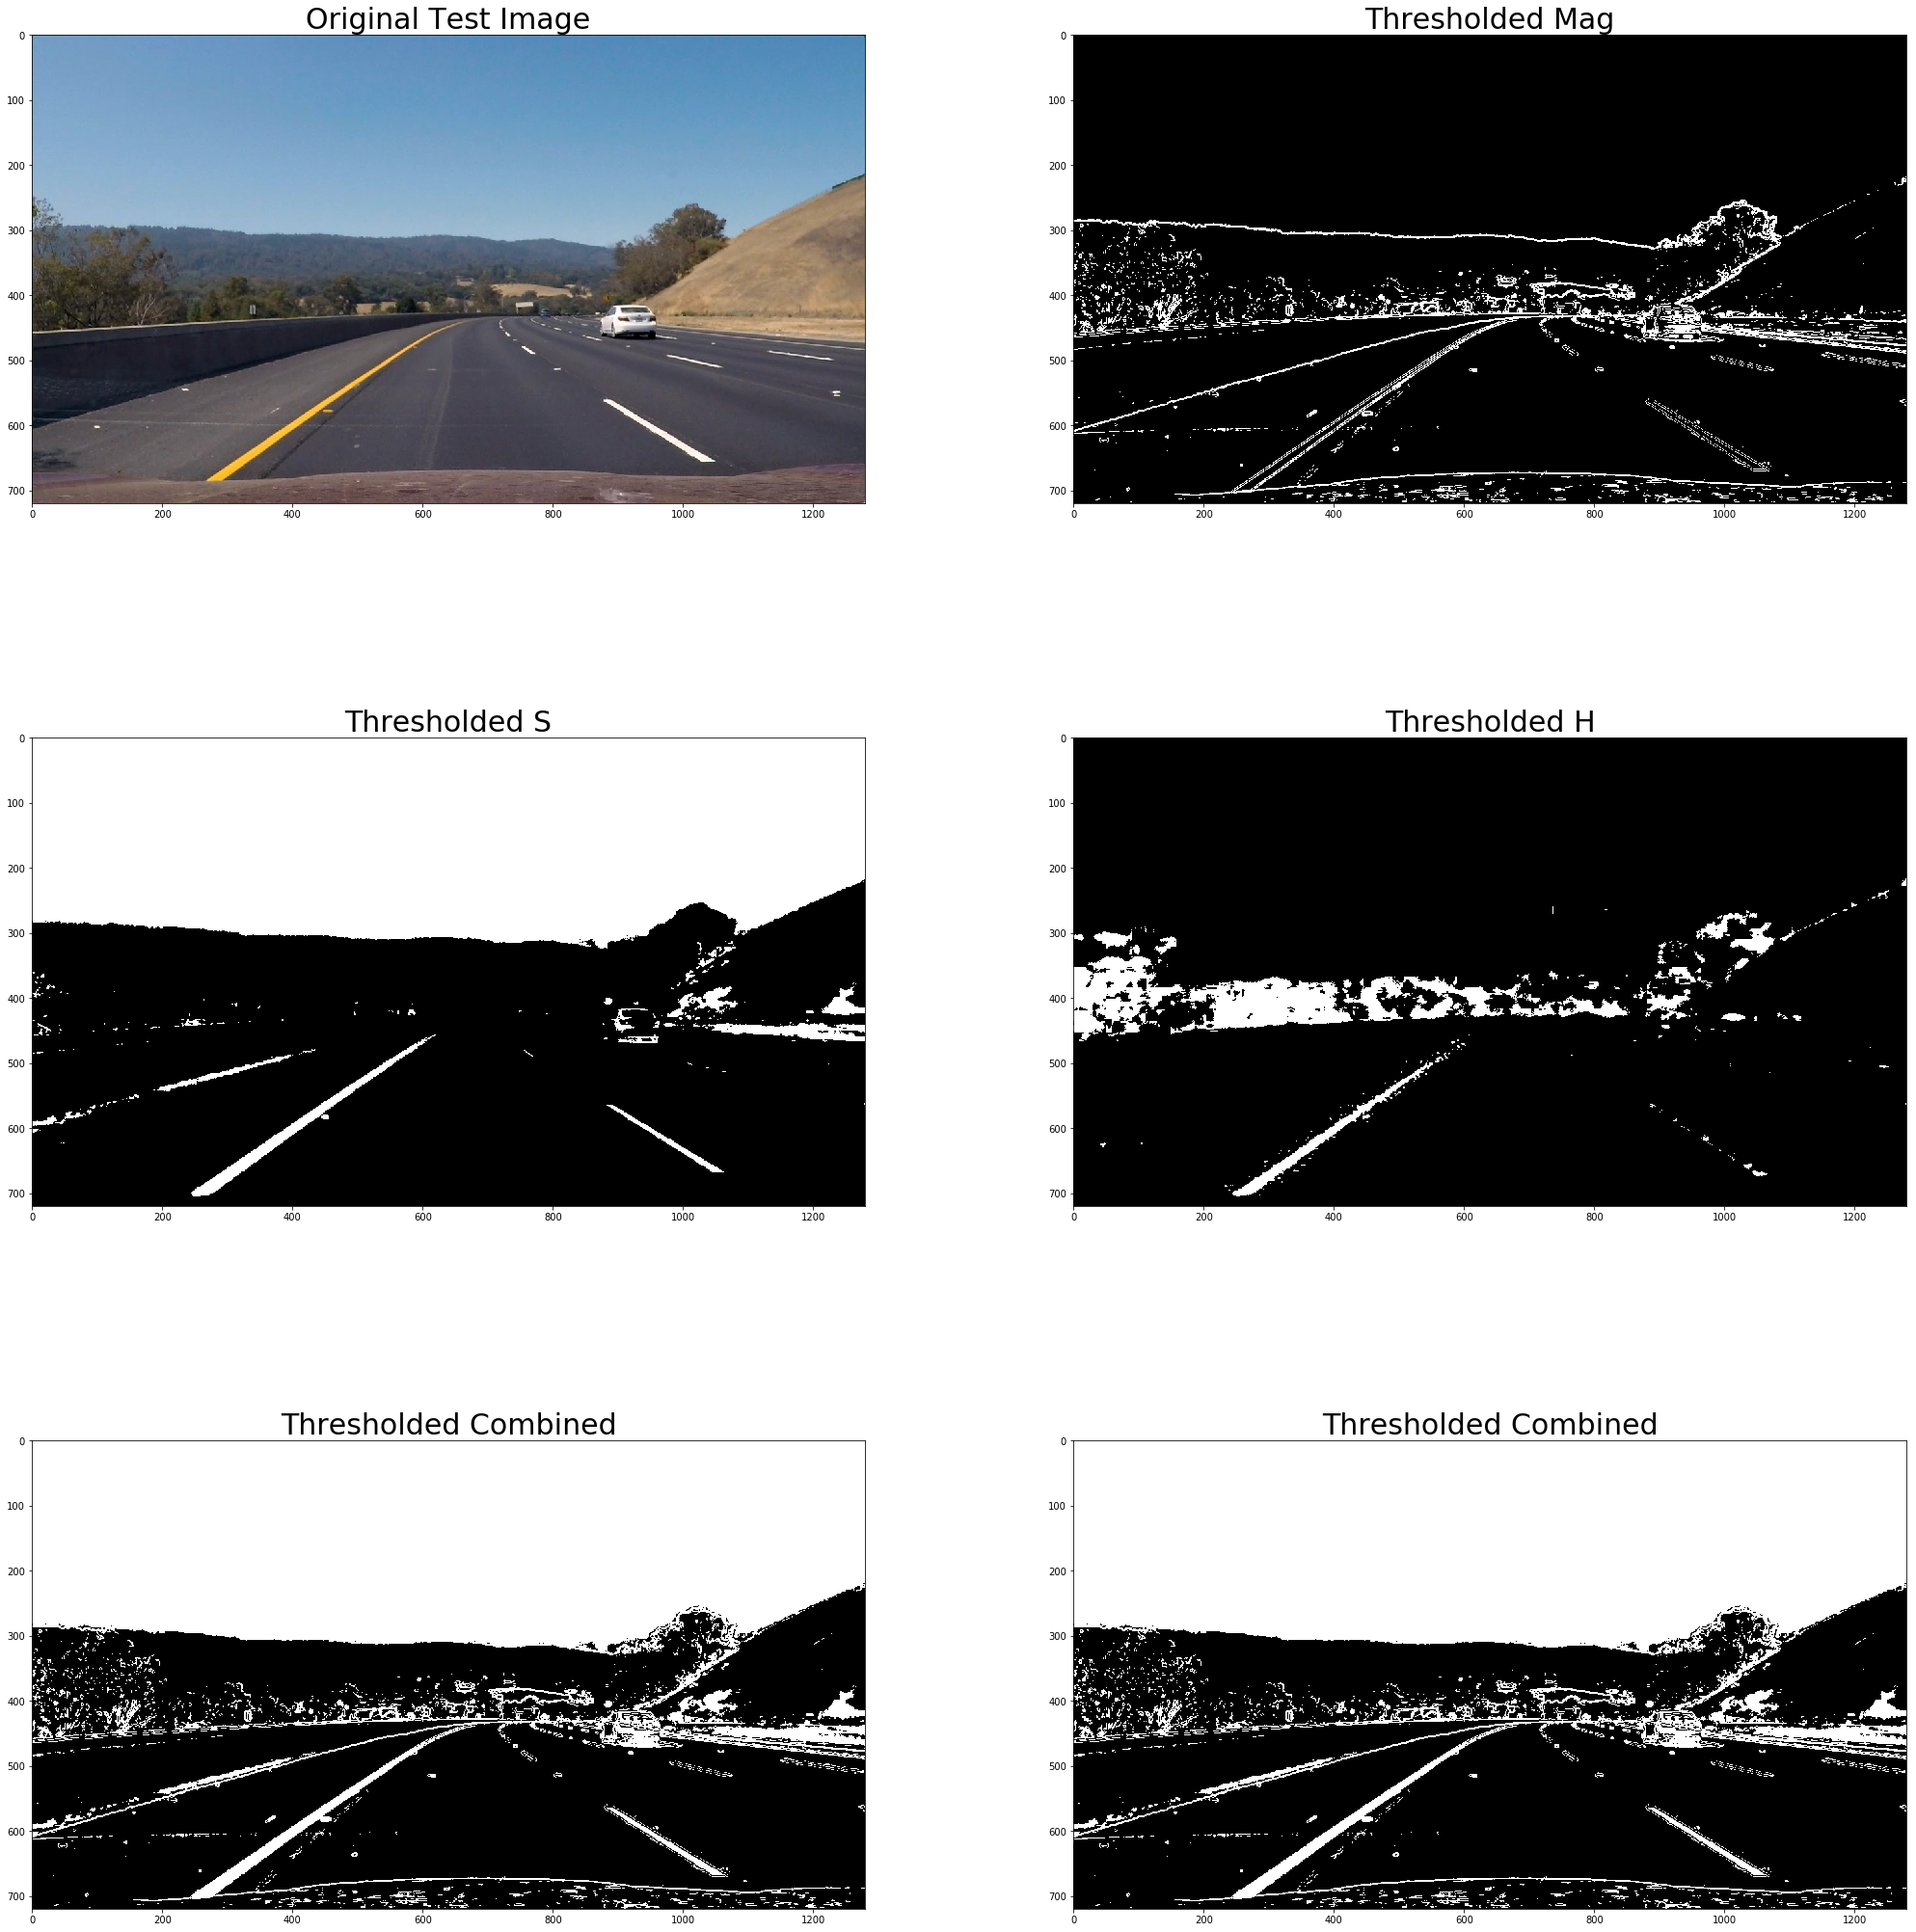

In [63]:
s_binary = s_select(undist_img, s_thresh=(80, 255))

h_binary = h_select(undist_img, h_thresh=(18,100))

mag_binary = mag_select(undist_img, sobel_kernel=3, mag_thresh=(20, 100))

combined = np.zeros_like(undist_img)
combined = threshold_pipeline(undist_img)

print('combined size:{}'.format(combined.shape))

f1, [(ax11, ax12), (ax21, ax22), (ax31, ax32)] = plt.subplots(3, 2, figsize=(30, 30))
f1.tight_layout()

ax11.imshow(test_img)
ax11.set_title('Original Test Image', fontsize=30)

ax12.imshow(mag_binary, cmap='gray')
ax12.set_title('Thresholded Mag', fontsize=30)

ax21.imshow(s_binary, cmap='gray')
ax21.set_title('Thresholded S', fontsize=30)

ax22.imshow(h_binary, cmap='gray')
ax22.set_title('Thresholded H', fontsize=30)

ax31.imshow(combined, cmap='gray')
ax31.set_title('Thresholded Combined', fontsize=30)

ax32.imshow(combined, cmap='gray')
ax32.set_title('Thresholded Combined', fontsize=30)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0., \
                    wspace=0., hspace=0.5)

In [64]:
final_thre = combined

## 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

### The code for my perspective transform includes a function called 'warper()', which appears in lines 1 through 8 in the file 'example.py'.


In [65]:
def warper(img, src, dst):

    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [66]:
img_width, img_height = (final_thre.shape[1], final_thre.shape[0])
print('width, height : {}, {}'.format(img_width, img_height))

offset = 100
src = np.float32([[(img_width/2) - 55, img_height/2 + 100],
                  [(img_width/6) - 10, img_height],
                  [(img_width*5/6) + 60, img_height],
                  [(img_width/2 + 55), img_height/2 + 100]
                 ])
dst = np.float32([[(img_width/4), 0],
                  [(img_width/4), img_height],
                  [(img_width*3/4), img_height],
                  [(img_width*3/4), 0]])

#src = np.float32([[585, 460],
#                  [203, 650],
#                  [1127, 650],
#                  [695, 460]
#                 ])
#dst = np.float32([[320, 0],
#                  [320, 650],
#                  [960, 650],
#                  [960, 0]])

top_down = warper(final_thre, src, dst)

width, height : 1280, 720


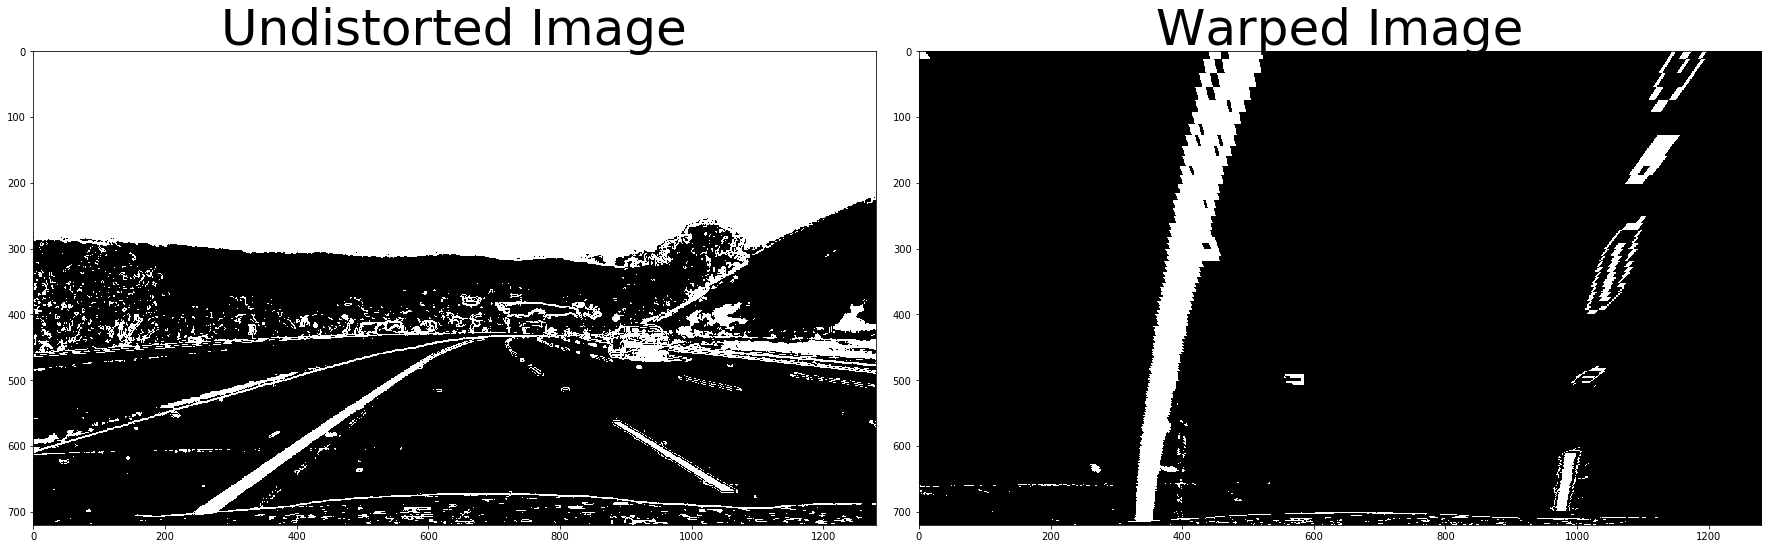

In [67]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(final_thre, cmap='gray')
ax1.set_title('Undistorted Image', fontsize=50)
ax2.imshow(top_down, cmap='gray')
ax2.set_title('Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

In [68]:
# Load image - this should be a new frame since last time!
binary_warped = top_down

In [69]:
def find_lane_pixels(binary_warped):
    # Step 1.split the histogram into two sides, one for each lane line.
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
 
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        #print('win_y_low:{}'.format(win_y_low))
        #print('win_y_high:{}'.format(win_y_high))
        
        ### TO-DO: Find the four below boundaries of the window ###
        win_xleft_low = (leftx_current - margin)  # Update this
        win_xleft_high = (leftx_current + margin)  # Update this
        win_xright_low = (rightx_current - margin)  # Update this
        win_xright_high = (rightx_current + margin) # Update this
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        ### TO-DO: Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & \
        (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### TO-DO: If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

In [70]:
leftx, lefty, rightx, righty = find_lane_pixels(binary_warped)

### TO-DO: Fit a second order polynomial to each using `np.polyfit` ###
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

In [71]:
# Polynomial fit values from the previous frame
# Make sure to grab the actual values from the previous step in your project!
#left_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
#right_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def fit_poly(img_shape, leftx, lefty, rightx, righty):
    ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

def search_around_poly(binary_warped, left_fit, right_fit):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +\
                        left_fit[2] - margin)) &\
                     (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy +\
                        left_fit[2] + margin)))    
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +\
                        right_fit[2] - margin)) &\
                     (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy +\
                        right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty)
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    #plt.plot(left_fitx, ploty, color='yellow')
    #plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

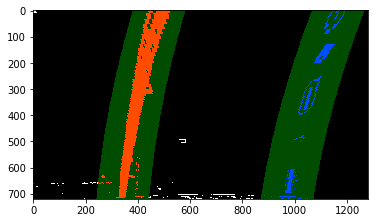

In [72]:
# Run image through the pipeline
# Note that in your project, you'll also want to feed in the previous fits
result = search_around_poly(binary_warped, left_fit, right_fit)

# View your output
plt.imshow(result)

## 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

In [73]:
left_fit

array([  1.48109467e-04,  -2.99101462e-01,   4.82540576e+02])

In [74]:
right_fit

array([  1.65713627e-04,  -3.90216467e-01,   1.16733919e+03])

In [75]:
def generate_data():
    '''
    Generates fake data to use for calculating lane curvature.
    In your own project, you'll ignore this function and instead
    feed in the output of your lane detection algorithm to
    the lane curvature calculation.
    '''
    # Set random seed number so results are consistent for grader
    # Comment this out if you'd like to see results on different random data!
    np.random.seed(0)
    # Generate some fake data to represent lane-line pixels
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
    # For each y position generate random x position within +/-50 pix
    # of the line base position in each case (x=200 for left, and x=900 for right)
    leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])
    rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                    for y in ploty])

    leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
    rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


    # Fit a second order polynomial to pixel positions in each fake lane line
    left_fit = np.polyfit(ploty, leftx, 2)
    right_fit = np.polyfit(ploty, rightx, 2)
    
    return ploty, left_fit, right_fit

    
def measure_curvature_real(left_fit, right_fit, img):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Make sure to feed in your real data instead in your project!
    ploty = np.linspace(0, 719, num=720)
    image_size = img.shape
    #print('image_size : {},{}'.format(image_size[0], image_size[1]))
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    ym_per_pix = 30/720  # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    #left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    #right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    ##### TO-DO: Implement the calculation of R_curve (radius of curvature) #####
    left_1st_D = 2*left_fit[0]*y_eval + left_fit[1]
    left_2nd_D = np.abs(2*left_fit[0])
    left_curverad = np.sqrt(np.power((1+left_1st_D**2),3)) / (left_2nd_D)
    
    right_1st_D = 2*right_fit[0]*y_eval + right_fit[1]
    right_2nd_D = np.abs(2*right_fit[0])
    right_curverad = np.sqrt(np.power((1+right_1st_D**2),3)) / (right_2nd_D)
    
    # Average curvature
    avg_curvature = (left_curverad + right_curverad)/2
    
    # Vehicle Position
    bottom_y = img.shape[0]
    left_lane_x = left_fit[0]*bottom_y**2 + left_fit[1]*bottom_y + left_fit[2]
    right_lane_x = right_fit[0]*bottom_y**2 + right_fit[1]*bottom_y + right_fit[2]
    
    # Find lane center in pixel unit
    lane_center = (left_lane_x + right_lane_x)/2.
    offset_pixel = image_size[1]/2 - lane_center
    lane_offset_center_meter = offset_pixel*xm_per_pix
    
    
    return avg_curvature, lane_offset_center_meter

In [76]:
# Calculate the radius of curvature in pixels for both lane lines
avg_curvature, lane_center_meter = measure_curvature_real(left_fit, right_fit, result)

print('Radius of Curvature = {}(m)'.format(avg_curvature))
print('Lane cener meter = {}(m)'.format(lane_center_meter))

Radius of Curvature = 3267.9088494(m)
Lane cener meter = -0.0958213958813(m)


## TEST: visual_display()

In [77]:
def visual_display(binary_warped, left_fit, right_fit, undistorted_image, src, dst):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Compute left_fitx and right_fitx
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255,0))
    
    inverse_bird_view = warper(color_warp,dst, src)
    
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_image, 1, inverse_bird_view, 0.3, 0)
    
    return result

In [78]:
def plot_output(name_str, image): 
    plt.imshow(image)
    plt.title(name_str)
    plt.show()

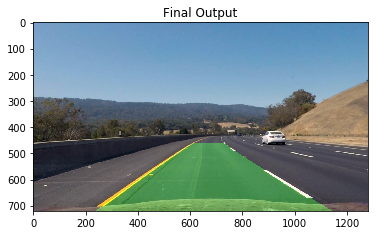

In [79]:
final_result = visual_display(top_down, left_fit, right_fit, undist_img, src, dst)

def plot_output(name_str, image): 
    plt.imshow(image)
    plt.title(name_str)
    plt.show()


plot_output("Final Output", final_result)